In [12]:
%run setup.ipynb
random.seed(42)
np.random.seed(42)
from pathlib import Path

In [14]:
my_file = Path('pca_data.npz')

In [15]:
my_file

PosixPath('pca_data.npz')

In [16]:
if my_file.is_file():
    # file exist
    print('pook')
else:
    print('snook')

pook


In [17]:
def snp_select():
    
    callset = phase2_ar1.callset_pass_biallelic['3L']

    regions = (("3R", 1000000, 37000000, "free"),
               ("3L", 15000000, 41000000, "free"))

    chrom = '3L'

    #get genotypes
    g = allel.GenotypeChunkedArray(callset['calldata']['genotype'])

    #get positions
    p = allel.VariantChunkedTable(callset['variants'],
                                     names=['POS'],
                                     index='POS')
    pos = p.POS[:]

    #just keep positions within the free region
    pos_free = pos[(pos > 15000000) * (pos < 41000000)] 
    free_b = p.index.locate_keys(pos_free)
    g_snp = g.compress(free_b, axis=0)

    #filter - no missing data
    ac = g_snp.count_alleles()
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g_snp.compress(flt, axis=0)

    #turn the genotype array into 2D matrix of non_ref alleles per call
    gn = gf.to_n_alt()

    #randomly select snps
    n = 100000
    vidx = np.random.choice(gn.shape[0], n, replace=False)
    vidx.sort()
    gnr = gn.take(vidx, axis=0)
    
    return gnr



def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [18]:
gnr = snp_select()

In [3]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [ ]:
my_file = Path('pca_data.npz')

In [ ]:
if my_file.is_file():
    # file exist
    print('pook')
    #load data
else:
    print('snook')
    #run select
    #run prune
    #run pca

In [ ]:
#basically here we should have all the plotting data we need by hook or crook

In [4]:
gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=10)

iteration 1 retaining 66272 removing 33728 variants
iteration 2 retaining 59390 removing 6882 variants
iteration 3 retaining 57090 removing 2300 variants
iteration 4 retaining 56010 removing 1080 variants
iteration 5 retaining 55349 removing 661 variants
iteration 6 retaining 54942 removing 407 variants
iteration 7 retaining 54646 removing 296 variants
iteration 8 retaining 54380 removing 266 variants
iteration 9 retaining 54209 removing 171 variants
iteration 10 retaining 54075 removing 134 variants


In [5]:
#performed PCA
coords1, model1 = allel.pca(gnu, n_components=20, scaler='patterson')

In [8]:
np.savez_compressed('pca_data.npz', 
                    coords=coords1, loadings=model1.components_, 
                    variance=model1.explained_variance_ratio_) 

In [34]:
# #save these files so we don't have to run everything above again
# #try not to use pickle!
# np.save('pca_coords1', coords1)

In [37]:
# #not sure how else to save the model type though (asking AM)
# pickle.dump(model1, open("pca_model1", "wb"))

## for figure - run from here

In [9]:
pca = np.load('pca_data.npz')
# access the arrays....
coords1 = pca['coords']
b = pca['loadings']
c = pca['variance']

In [12]:
c

array([0.00833426, 0.00729087, 0.00502358, 0.00413514, 0.0037697 ,
       0.00363803, 0.00191274, 0.00186113, 0.00175125, 0.0017299 ,
       0.00169587, 0.00163375, 0.00158592, 0.00156389, 0.00153547,
       0.00150278, 0.00148858, 0.00147664, 0.00145979, 0.00143789])

In [39]:
#load
coords1 = np.load('pca_coords1.npy')
file = open('pca_model1', 'rb')
model1 = pickle.load(file)

In [177]:
type(model1)

allel.stats.decomposition.GenotypePCA

In [164]:
# plotting setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
rcParams = plt.rcParams
rcParams['font.size'] = 8
#rcParams['font.family'] = 'arial'
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['axes.linewidth'] = .9
rcParams['lines.linewidth'] = .9
rcParams['patch.linewidth'] = .9
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
rcParams['savefig.jpeg_quality'] = 100
rcParams['savefig.dpi'] = 120
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.figsize'] = (4.85, 3)

In [165]:
pop_colours = {
    'AOcol': '#9f3703',
    'BFcol': '#f67824',
    'BFgam': '#562c91',
    'CIcol': '#feb13f',
    'CMgam': '#705da9',
    'FRgam': '#0b559f',
    'GAgam': '#2a7ab9',
    'GHcol': '#f44e38',
    'GHgam': '#88bedc',
    'GM': '#5b5b5b',
    'GNcol': '#a91016',
    'GNgam': '#8ed08b',
    'GQgam': '#56b567',
    'GW': '#acacac',
    'KE': '#2a2a2a',
    'UGgam': '#04702f'
}


marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

In [166]:
#get samples
df_samples = pd.read_csv('/kwiat/vector/ag1000g/release/phase2.AR1/samples/samples.meta.txt', delimiter='\t')
all_samp=list(df_samples.ox_code)

In [167]:
all_samp=list(df_samples.ox_code)
len(all_samp)

1142

In [168]:
populations = df_samples.population.unique()
populations, len(df_samples.population)

(array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'UGgam', 'GM', 'GW', 'KE',
        'CMgam', 'FRgam', 'GQgam', 'AOcol', 'GAgam', 'GNgam', 'GNcol',
        'CIcol'], dtype=object), 1142)

In [169]:
#dictionary+list comprehension to create a dictionary of lists of indexes!
idx_dict = {popz: [i for i, j in enumerate(all_samp) if j == popz] for popz in populations}

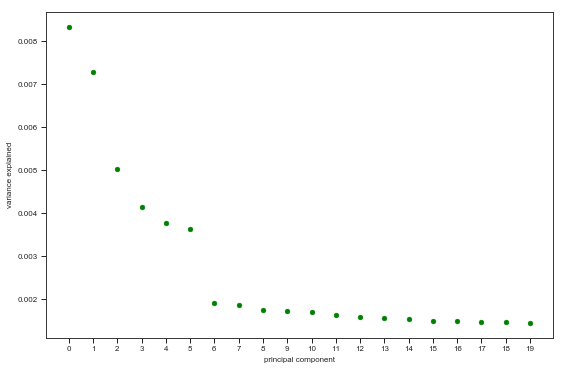

In [194]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
ax.plot(model1.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

In [171]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style[pop], linestyle=' ', color=pop_colours[pop], label=pop, markersize=6, mec='k', mew=0.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    fn = 'Phase_2_'+chrom+'_pca.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

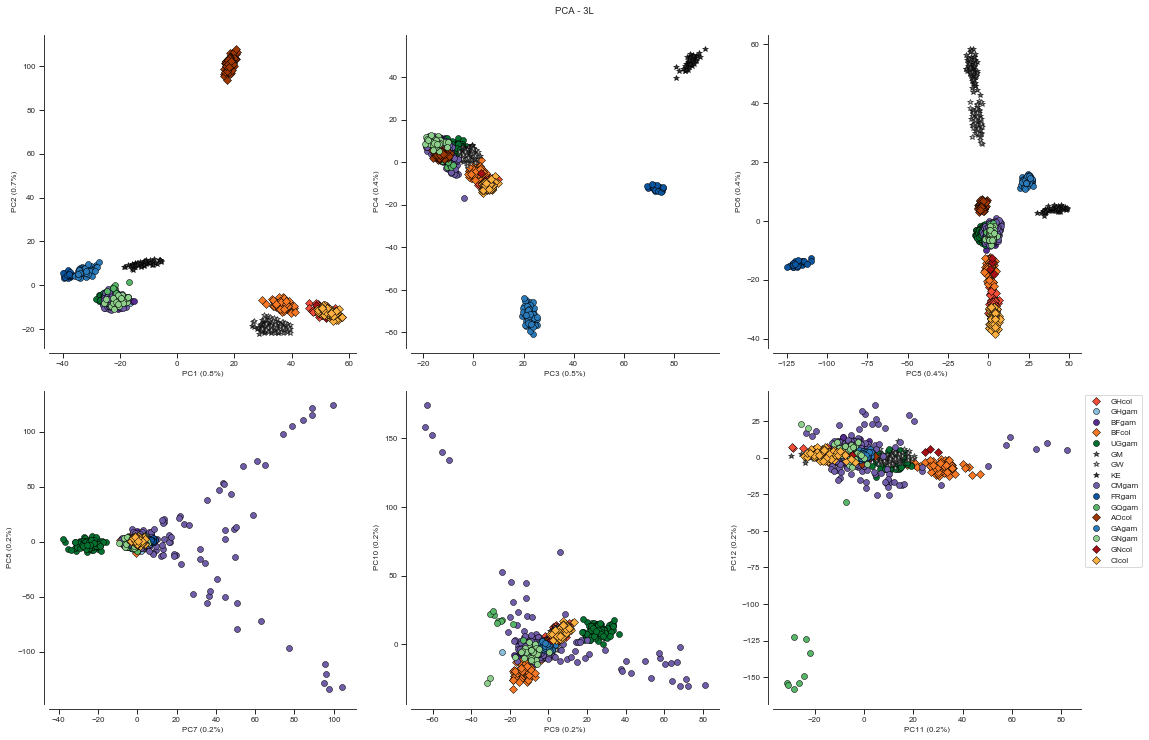

In [172]:
fig_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## main text figure

In [188]:
def fig_main_pca(coords, model, title, sample_population):
    fig = plt.figure(figsize=(12, 5))
    
    ax = fig.add_subplot(121)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(122)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=13, framealpha=0.1)
    fig.tight_layout()
    fn = 'Phase_2_'+chrom+'_main_text_pca.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

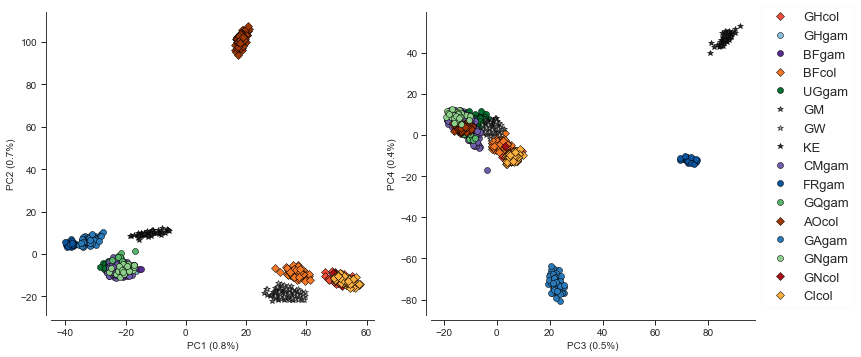

In [189]:
fig_main_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## supplementary figure

In [237]:
def fig_supp_pca(coords, model, title, sample_population):
    
    fig = plt.figure(figsize=(18, 5))
    
    ax = fig.add_subplot(131)
    sns.despine(ax=ax, offset=5)
    x = np.arange(model1.explained_variance_ratio_.shape[0])
    y = model1.explained_variance_ratio_ * 100
    ax.bar(x+.2, y, width=.6, align='edge', color='darkgray')
    ax.set_xticks(x+.5)
    ax.set_xticklabels(x+1, fontsize=7)
    ax.set_ylabel('Variance explained (\%)')
    ax.set_xlabel('Principal component')
    ax.set_xlim(0, 20)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
        
    ax = fig.add_subplot(132)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(133)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=12, framealpha=0.1)
    
    fig.tight_layout()
    fn = 'Phase_2_'+chrom+'_supplementary_pca.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

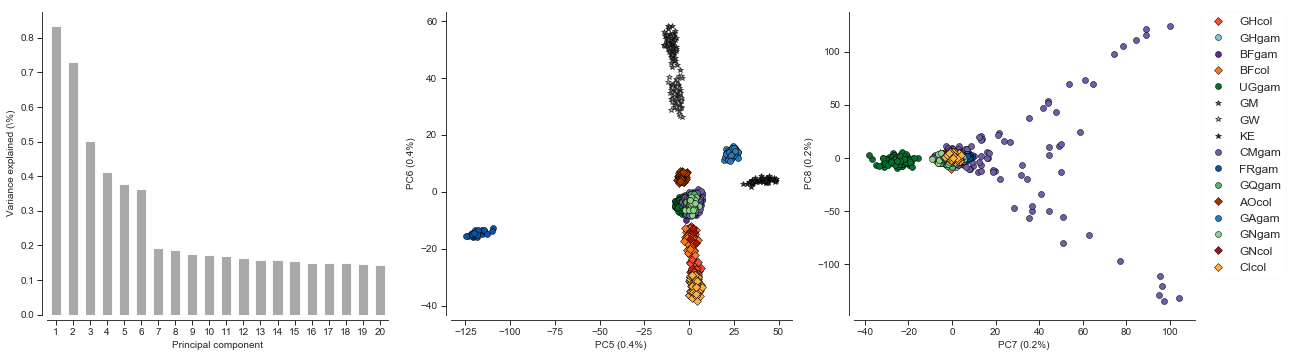

In [238]:
fig_supp_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)